# a spring coupled mass simulator to create positions of mechanisms and purviews of a CES 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext blackcellmagic

In [3]:
import numpy as np
import math
import pickle as pkl
from scipy.special import comb

from pyphi import visualize as viz
from pyphi import relations as rel

import matplotlib.pyplot as plt
import string

import random
import imageio


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [19]:

def compute_forces(
    x,
    y,
    z,
    vx,
    vy,
    vz,
    spring_constants,
    friction_factor=1,
    repulsion_factor=1,
    spring_factor=1,
):

    N = len(x)
    Fx = []
    Fy = []
    Fz = []
    for i in range(N):

        F = np.zeros(3)
        for j in range(N):
            if i != j:
                # computing distance
                distance_vector = [x[i] - x[j], y[i] - y[j], z[i] - z[j]]
                distance = np.sqrt(np.sum([d ** 2 for d in distance_vector]))
                
                # making sure distance is not 0
                if distance<0.1:
                    distance_vector = 0.05+np.random.rand(3)*0.1
                    distance = np.sqrt(np.sum([d ** 2 for d in distance_vector]))
                unit_vector = [d / distance for d in distance_vector]

                # computing spring forces
                spring_force_magnitude = (
                    distance * spring_constants[i, j] * spring_factor
                )
                spring_force_vector = np.array(
                    [-spring_force_magnitude * u for u in unit_vector]
                )

                # computing repulsive force
                repulsive_force_magnitude = np.sum(spring_constants[j,:]) * repulsion_factor / (distance**2) / N
                repulsive_force_vector = np.array(
                    [repulsive_force_magnitude * u for u in unit_vector]
                )

                # summing total forces
                F += spring_force_vector + repulsive_force_vector

        # computing friction force
        total_speed = np.sqrt(vx[i] ** 2 + vy[i] ** 2 + vz[i] ** 2)
        friction_magnitude = total_speed * friction_factor
        friction_vector = np.array(
            [
                friction_magnitude * v / total_speed if total_speed > 0 else 0
                for v in [vx[i], vy[i], vz[i]]
            ]
        )
        
        Fx.append(F[0] - friction_vector[0])
        Fy.append(F[1] - friction_vector[1])
        Fz.append(F[2] - friction_vector[2])

    return Fx, Fy, Fz


def update_position_and_velocity(x, y, z, vx, vy, vz, Fx, Fy, Fz, delta, mass=None):
    if mass == None:
        mass = np.ones(len(x))

    for i in range(len(x)):
        ax = Fx[i] / mass[i]
        ay = Fy[i] / mass[i]
        az = Fz[i] / mass[i]
        vx[i] = vx[i] + (ax * delta)
        vy[i] = vy[i] + (ay * delta)
        vz[i] = vz[i] + (az * delta)
        x[i] = x[i] + (vx[i] * delta)
        y[i] = y[i] + (vy[i] * delta)
        z[i] = z[i] + (vz[i] * delta)

    return x, y, z, vx, vy, vz


def equilibrate(
    spring_constants,
    x,
    y,
    z=None,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=2,
    repulsion_factor=1,
    spring_factor=1,
    T=100,
    delta=0.1,
    mass=None,
    immovable=[]
):
    if z is None:
        z = np.zeros(len(x))
    if vx is None:
        vx = np.zeros(len(x))
    if vy is None:
        vy = np.zeros(len(x))
    if vz is None:
        vz = np.zeros(len(x))

    path = []
    for t in range(T):
        Fx, Fy, Fz = compute_forces(
            x,
            y,
            z,
            vx,
            vy,
            vz,
            spring_constants,
            friction_factor,
            repulsion_factor,
            spring_factor,
        )
        
        # removing forces and velocities from immovable components
        for i in immovable:
            Fx[i],Fy[i],Fz[i],vx[i],vy[i],vz[i] = 0,0,0,0,0,0
        
        x, y, z, vx, vy, vz = update_position_and_velocity(
            x, y, z, vx, vy, vz, Fx, Fy, Fz, delta, mass
        )
        
        path.append([x.copy(), y.copy(), z.copy()])

    return np.array(path)


def initialize_positions(ces, center=(1, 1), z=0, radius=1,purview_scale=0.9,mech_base=True):
    
    if mech_base:
        aux = construct_mechanism_base(len(ces[-1].mechanism),center,0.1,0.1)
        mechs = [m for mm in aux for m in mm]
    else:
        mechs = viz.regular_polygon(
            len(ces), center=center, angle=0, z=0, radius=radius, scale=1
        )
        
    purviews = viz.regular_polygon(
        2 * len(ces),
        center=center,
        angle=math.pi / (len(ces)),
        z=0,
        radius=radius,
        scale=purview_scale,
    )
    
    xyz = np.array(mechs + purviews)
    
    return (xyz[:,0],xyz[:,1],xyz[:,2])


def get_interactions(ces, rels, adjustment_factor=1, adjust_force_by_phi=True):

    separated_ces = rel.separate_ces(ces)
    N = len(ces)
    M = len(separated_ces)

    # denote what components each purview will be affected by
    # first the mechanisms
    features_mechs = np.zeros((M, N))
    for i in range(N):
        features_mechs[2 * i : 2 * i + 2, i] = 1

    # next the relations
    features_rels = viz.feature_matrix(rel.separate_ces(ces), rels)
    features_rels = viz.feature_matrix(rel.separate_ces(ces), rels)
    # features now contains information about any distinction or relation each purview is associated to
    
    # next, we exchange the 1's with phi values
    if adjust_force_by_phi:
        # frist for distinctions
        for i in range(M):
            features_mechs[i, :] *= separated_ces[i].phi

        for i in range(len(rels)):
            features_rels[:, i] *= rels[i].phi / len(rels[i].relata)

    # getting the interactions between constituents
    interactions = np.zeros((N + M, N + M))

    # filling with mechanism-purview interactions
    interactions[N:, :N] = features_mechs
    interactions[:N, N:] = np.transpose(features_mechs)

    # now for the purview-purview interactions
    purview_purview = np.zeros((M, M))
    for i, feature in enumerate(features_rels):
        for r in feature.nonzero()[0]:
            for j in features_rels[:, r].nonzero()[0]:
                if not i == j:
                    purview_purview[i, j] += feature[r]
                    purview_purview[j, i] += feature[r]

    # renormalizing to have same max as mechanisms interactions
    purview_purview = (
        adjustment_factor
        * np.max(interactions[N:, :N])
        * purview_purview
        / (np.max(np.sum(purview_purview, axis=1)))
    )

    interactions[N:, N:] = purview_purview

    return interactions/interactions.mean()


def construct_mechanism_base(N,base_center,base_floor_height,base_scale):
    return [
            viz.regular_polygon(
                int(comb(N, k)),
                center=base_center,
                z=((k / N) * base_floor_height),
                scale=base_scale,
            )
        for k in range(1, N + 1)
    ]


# Chapter 3 system

In [20]:
with open(r"ch3_ces.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"ch3_rels.pkl", "rb") as f:
    rels = pkl.load(f)
    
with open(r"ch3_subsystem.pkl", "rb") as f:
    system = pkl.load(f)

In [32]:
def spring_force_simulation(
    ces,
    rels,
    distinction_relation_force_balance=1,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=300,
    delta=0.01,
    mass=None,
    immovable=(),
    initial_positions="singularity",
    return_path=False,
    adjust_force_by_phi=True,
):
    # Get the spring forces between all terms
    spring_constants = get_interactions(
        ces, rels, distinction_relation_force_balance, adjust_force_by_phi
    )

    # initialize positions based on input argument
    x, y, z = get_initial_positions(initial_positions)

    # simulating the spring force system
    path = equilibrate(
        spring_constants,
        x,
        y,
        z,
        friction_factor=friction_factor,
        repulsion_factor=repulsion_factor,
        spring_factor=spring_factor,
        T=T,
        delta=delta,
        mass=mass,
        immovable=immovable,
    )

    if return_path:
        return path
    else:
        mech_coords = path[-1, :, : len(ces)]
        purv_coords = path[-1, :, len(ces) :]
        return mech_coords, purv_coords


def get_initial_positions(initial_positions):

    if initial_positions == "singularity":
        x = np.zeros(len(spring_constants))
        y = np.zeros(len(spring_constants))
        z = np.zeros(len(spring_constants))

    elif initial_positions == "mechanisms inside":
        x, y, z = initialize_positions(
            ces, center=(0, 0), z=0, radius=0.1, purview_scale=3, mech_base=False
        )

    elif initial_positions == "mechanisms outside":
        x, y, z = initialize_positions(
            ces, center=(0, 0), z=0, radius=2, purview_scale=0.9, mech_base=False
        )

    elif initial_positions == "mechanism core":

        aux = construct_mechanism_base(len(ces[-1].mechanism), center, 0.1, 0.1)
        mechs = [m for mm in aux for m in mm]
        purviews = viz.regular_polygon(
            2 * len(ces),
            center=center,
            angle=math.pi / (len(ces)),
            z=0,
            radius=radius,
            scale=purview_scale,
        )
        xyz = np.array(mechs + purviews)
        x, y, z = (xyz[:, 0], xyz[:, 1], xyz[:, 2])
    else:
        # assuming intial positions are given
        x = initial_positions[0, :]
        y = initial_positions[1, :]
        z = initial_positions[2, :]

    return x, y, z

In [44]:
path = spring_force_simulation(
    ces,
    rels,
    T=100,
    return_path=True,
    distinction_relation_force_balance=10,
    immovable=range(len(ces)),
    initial_positions="mechanisms outside",
)

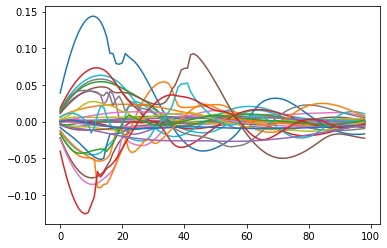

In [45]:
plt.plot(path[1:,1,:]-path[:-1,1,:]);

In [47]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='ch3_spring_random_static_mechs_small',
                             user_mechanism_coords=path[-1, :, : len(ces)],
                             user_purview_coords=path[-1, :, len(ces) :],
                             link_width_range=(1,3),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels=False,
                             save_plot_to_html=False,
                             png_name='pngs/ch3/frame1.png',
                             showlegend=False,
                            show_mechanism_labels=False,
                            show_mechanism_state_labels=False,
)

In [28]:
T=300
times = range(0,T,5)

filenames = []
for t in times:
    mech_coords = path[-1, :, : len(ces)]
    purv_coords = path[-1, :, len(ces) :]
    
    name = "pngs/ch3_circle/frame"+str(t)+".png"
    fig = viz.plot_ces_epicycles(
        system,
        ces,
        rels,
        network_name="ch3_spring_random_static_mechs_small",
        user_mechanism_coords=mech_coords,
        user_purview_coords=purv_coords,
        link_width_range=(1, 3),
        eye_coordinates=(0, 0, 1),
        mechanism_labels_size=8,
        purview_labels_size=8,
        mechanism_label_position="middle center",
        purview_label_position="middle center",
        show_purview_labels=False,
        save_plot_to_html=False,
        png_name=name,
        showlegend=False,
        show_mechanism_labels=False,
        show_mechanism_state_labels=False,
    )
    filenames.append(name)